In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [575]:
def show(im):
    plt.imshow(im.detach().cpu(), cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [3]:
import preprocess_data
import random
import torch
import matplotlib.pyplot as plt

In [4]:
dxa, _ = preprocess_data.dxa_dataset()

In [5]:
BATCH_SIZE=32

In [6]:
radio, _ = preprocess_data.radiograph_dataset()

GDCMImageIO (0x55c5d0c37f40): Converting from MONOCHROME1 to MONOCHROME2 may impact the meaning of DICOM attributes related to pixel values.



In [7]:
dxa_s = dxa[:, :, ::4, ::4]
radio_s = radio[:, :, ::4, ::4]

def make_batch():
    idx_dxa = range(len(dxa))
    idx_radio = range(len(radio))
    
    
    

    imgs = [
        dxa_s[random.choice(idx_dxa)][None] if (random.random() > .5) 
        else torch.flip(radio_s[random.choice(idx_radio)][None], dims=(3,))
        for i in range(BATCH_SIZE)
    ]
    return torch.cat(imgs).cuda().float()
    

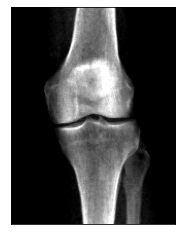

In [576]:
image_A, image_B = make_batch(), make_batch()
show(image_A[0, 0])

In [9]:
import itk
import numpy as np
import icon_registration as icon
import icon_registration.networks as networks
BATCH_SIZE = 128
inner_net = icon.FunctionFromVectorField(networks.tallUNet2(dimension=2))
for _ in range(3):
    inner_net = icon.TwoStepRegistration(
        icon.DownsampleRegistration(inner_net, 2), 
        icon.FunctionFromVectorField(networks.tallUNet2(dimension=2))
    )

netGrad = icon.GradientICON(
    inner_net,
    icon.LNCC(sigma=5),
    3
)
input_shape = make_batch().shape
netGrad.assign_identity_map(input_shape)
netGrad.cuda()
optimizerGrad = torch.optim.Adam(netGrad.parameters(), lr=0.0001)
netGrad.train()
0

0

In [17]:
netGrad.regis_net.load_state_dict(torch.load("results/mixed_train/network_weights_1500"))

<All keys matched successfully>

In [ ]:
import importlib
importlib.reload(icon.train)
importlib.reload(icon)
icon.train_batchfunction(netGrad, optimizerGrad, lambda : (make_batch(), make_batch()), steps=64000)

In [578]:
image_A, image_B = make_batch(), make_batch()


In [579]:
netGrad.regis_net.load_state_dict(torch.load("results/images/network_weights_40800"))
netGrad.eval()
with torch.no_grad():
     netGrad(image_A, image_B)

image_A


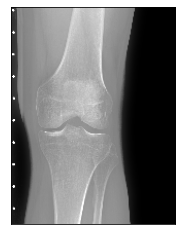

warped_image_B


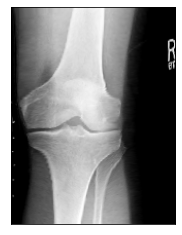

image_B


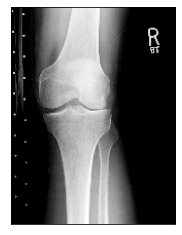

In [585]:
print("image_A")
show(image_A[5, 0])
print("warped_image_B")
show(netGrad.warped_image_B[5, 0])
print("image_B")
show(image_B[5, 0])

image_A


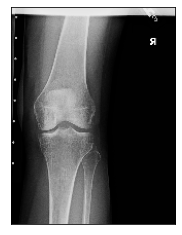

warped_image_B


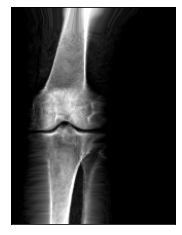

image_B


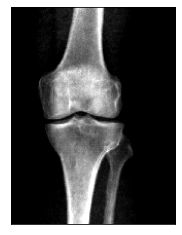

In [586]:
print("image_A")
show(image_A[7, 0])
print("warped_image_B")
show(netGrad.warped_image_B[7, 0])
print("image_B")
show(image_B[7, 0])

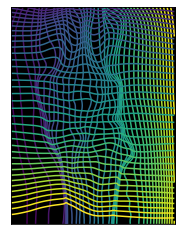

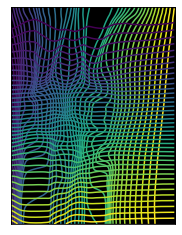

In [587]:
lines = np.arange(0, 1, 1/40)

plt.contour(netGrad.phi_AB_vectorfield[7, 1].detach().cpu(), lines)
plt.contour(netGrad.phi_AB_vectorfield[7, 0].detach().cpu(), lines)
show(image_A[0, 0] * 0)
plt.contour(netGrad.phi_BA_vectorfield[7, 1].detach().cpu(), lines)
plt.contour(netGrad.phi_BA_vectorfield[7, 0].detach().cpu(), lines)
show(image_A[0, 0] * 0)

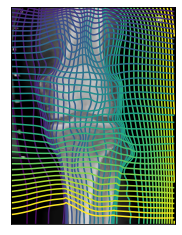

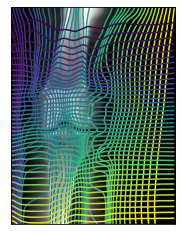

In [589]:
lines = np.arange(0, 1, 1/40)

plt.contour(netGrad.phi_AB_vectorfield[7, 1].detach().cpu(), lines)
plt.contour(netGrad.phi_AB_vectorfield[7, 0].detach().cpu(), lines)
show(netGrad.warped_image_A[7, 0])
plt.contour(netGrad.phi_BA_vectorfield[7, 1].detach().cpu(), lines)
plt.contour(netGrad.phi_BA_vectorfield[7, 0].detach().cpu(), lines)
show(netGrad.warped_image_B[7, 0])

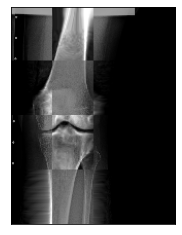

In [591]:
show(
    torch.tensor(
        itk.checker_board_image_filter(
            image_A[7, 0].cpu().numpy(), 
            netGrad.warped_image_B[7, 0].cpu().numpy()
        )
    )
)

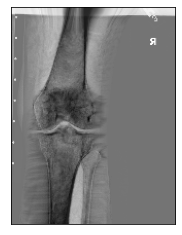

In [592]:
show((image_A[7, 0] - netGrad.warped_image_B[7, 0]))

In [593]:
atlas = torch.nn.Parameter(torch.randn(1, 1, 848 // 4, 640 // 4, device="cuda"))
with torch.no_grad():
    atlas[:] = torch.mean(dxa_s, axis=0, keepdims=True)

atlas_exp = atlas.expand(BATCH_SIZE, -1, -1, -1).cuda()
params = [atlas]

In [594]:
optim = torch.optim.Adam(params, lr=.1)


In [ ]:
for _ in range(1273):
    image_B = make_batch()
    optim.zero_grad()
    loss_obj = netGrad(atlas_exp, image_B)
    disp_direction_loss = torch.mean(torch.mean(netGrad.phi_AB_vectorfield - netGrad.identity_map, axis=0)**2)
    print(disp_direction_loss)
    (loss_obj.all_loss + 300 * disp_direction_loss).backward()
    optim.step()
    print(icon.losses.to_floats(loss_obj))
    # a "regularizer"
    with torch.no_grad():
        atlas[:] = torch.clip(atlas, 0, .4)

In [596]:
image_B = make_batch()
with torch.no_grad():
    netGrad(atlas.expand(128, -1, -1, -1).cuda(), image_B)

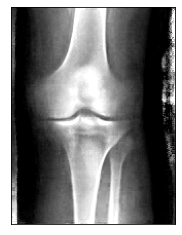

In [597]:
show(atlas[0, 0])

image


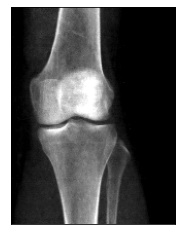

warped_atlas


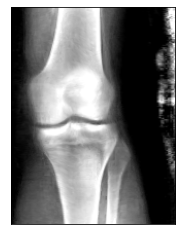

warped_image


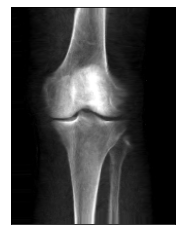

difference image


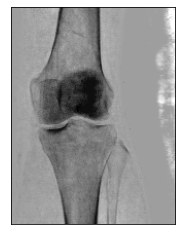

In [598]:
N += 1
N %= 128
print("image")
show(image_B[N, 0])
print("warped_atlas")
show(netGrad.warped_image_A[N, 0])
print("warped_image")
show(netGrad.warped_image_B[N, 0])
print("difference image")
show((netGrad.warped_image_A[N, 0]) - (image_B[N, 0]))

atlas_checkerboard


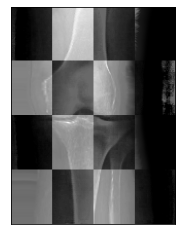

atlas_checkerboard


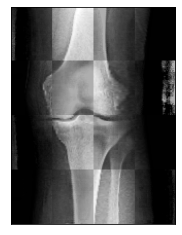

atlas_checkerboard


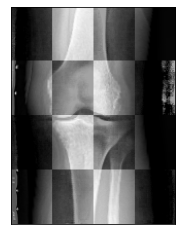

atlas_checkerboard


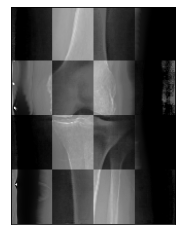

atlas_checkerboard


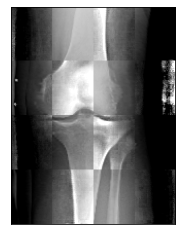

atlas_checkerboard


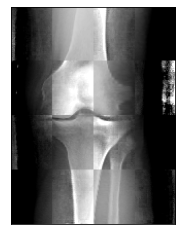

atlas_checkerboard


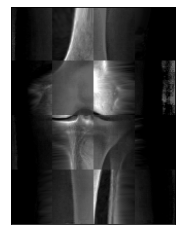

atlas_checkerboard


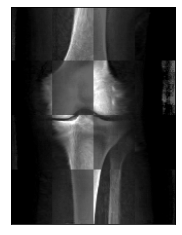

atlas_checkerboard


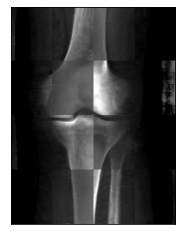

atlas_checkerboard


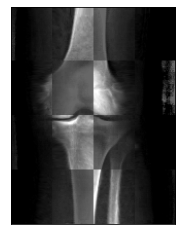

atlas_checkerboard


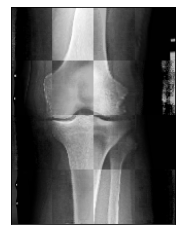

atlas_checkerboard


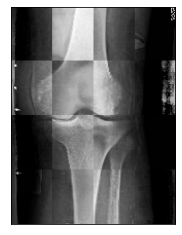

atlas_checkerboard


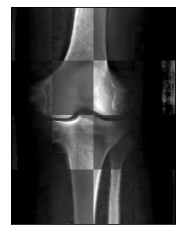

atlas_checkerboard


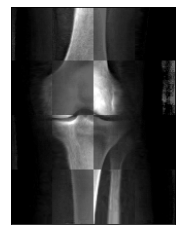

atlas_checkerboard


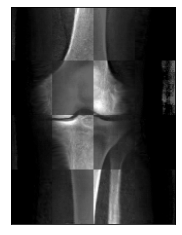

atlas_checkerboard


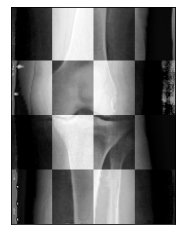

atlas_checkerboard


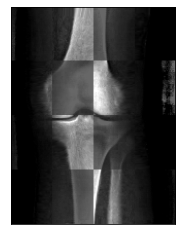

atlas_checkerboard


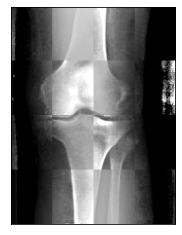

atlas_checkerboard


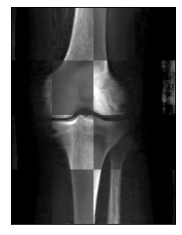

atlas_checkerboard


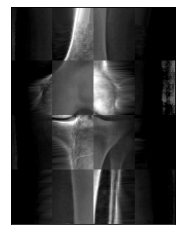

atlas_checkerboard


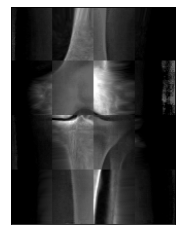

atlas_checkerboard


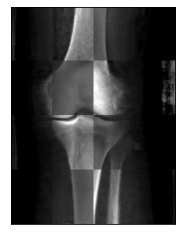

atlas_checkerboard


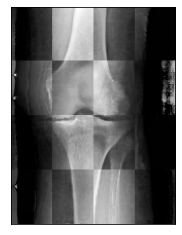

atlas_checkerboard


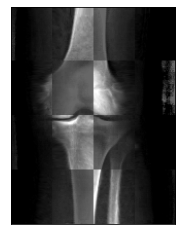

atlas_checkerboard


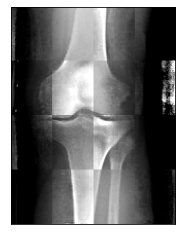

In [599]:
for _ in range(25):
    N += 1
    N %= 128
    print("atlas_checkerboard")
    show(
        torch.tensor(
            itk.checker_board_image_filter(
                atlas[0, 0].detach().cpu().numpy(), 
                netGrad.warped_image_B[N, 0].cpu().numpy()
            )
        )
    )

warped_image


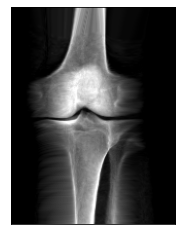

warped_image


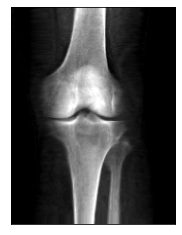

warped_image


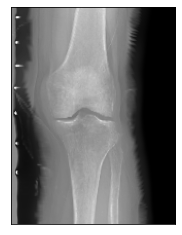

warped_image


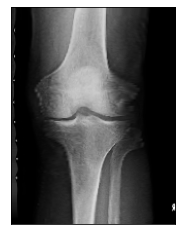

warped_image


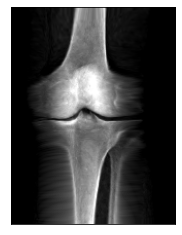

warped_image


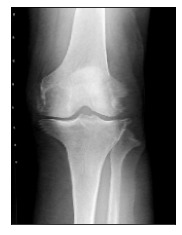

warped_image


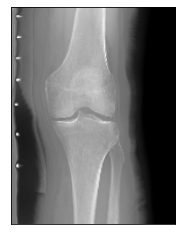

warped_image


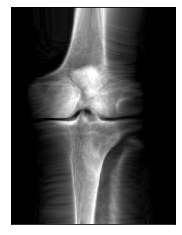

warped_image


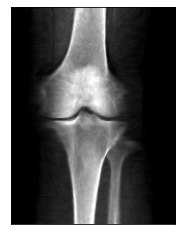

warped_image


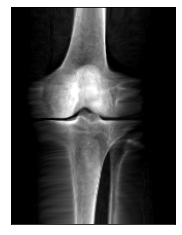

warped_image


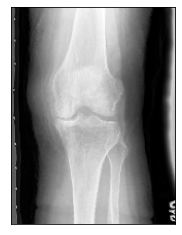

warped_image


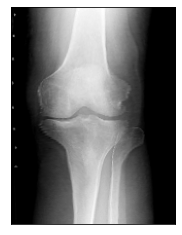

warped_image


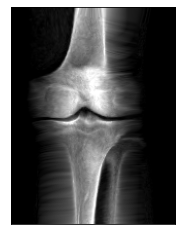

warped_image


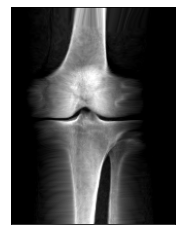

warped_image


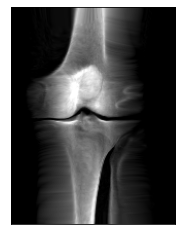

warped_image


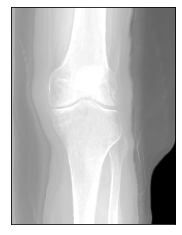

warped_image


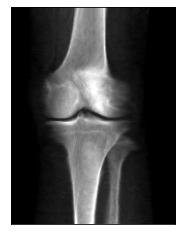

warped_image


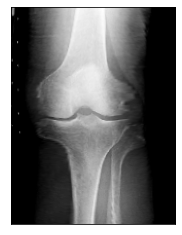

warped_image


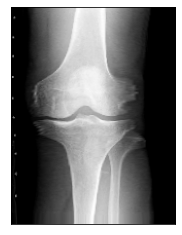

warped_image


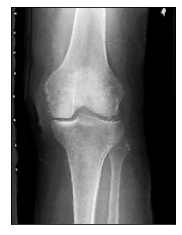

warped_image


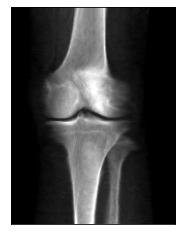

warped_image


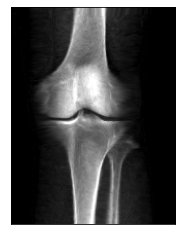

warped_image


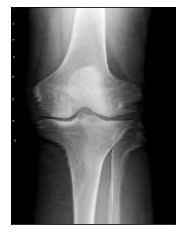

warped_image


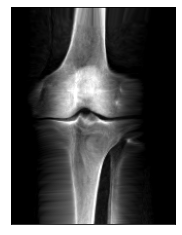

warped_image


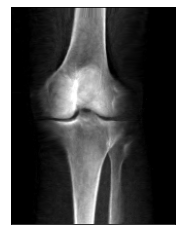

In [600]:
for _ in range(25):
    N += 1
    N %= 128
    print("warped_image")
    show(netGrad.warped_image_B[N, 0])

warped_image_grid


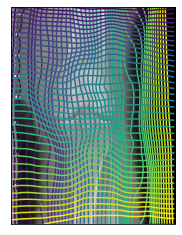

warped_image_grid


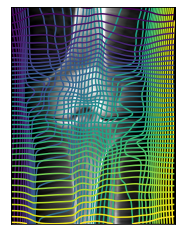

warped_image_grid


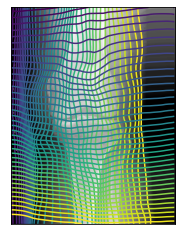

warped_image_grid


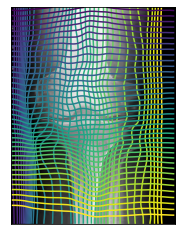

warped_image_grid


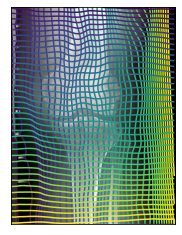

warped_image_grid


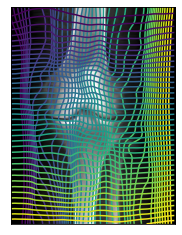

warped_image_grid


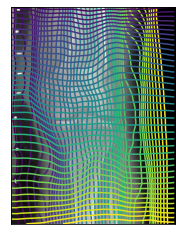

warped_image_grid


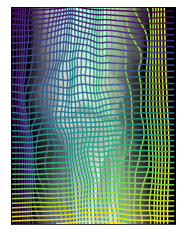

warped_image_grid


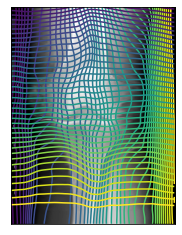

warped_image_grid


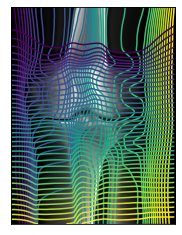

warped_image_grid


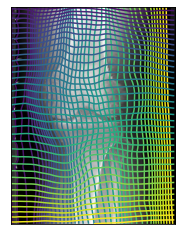

warped_image_grid


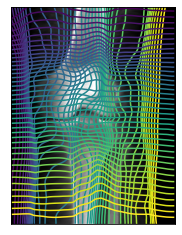

warped_image_grid


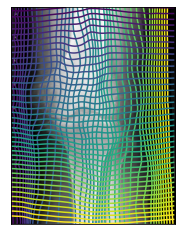

warped_image_grid


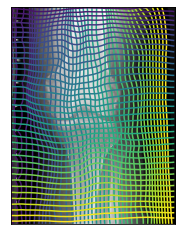

warped_image_grid


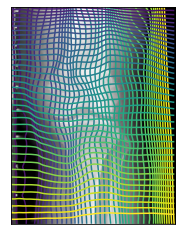

warped_image_grid


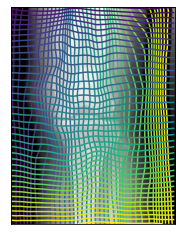

warped_image_grid


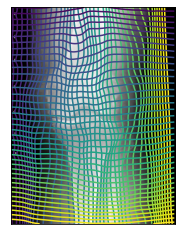

warped_image_grid


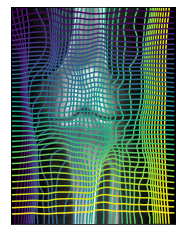

warped_image_grid


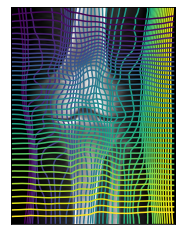

warped_image_grid


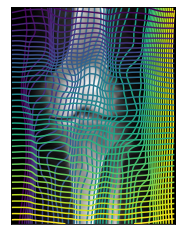

warped_image_grid


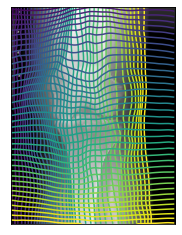

warped_image_grid


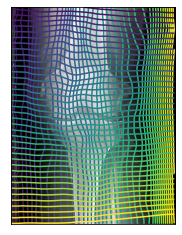

warped_image_grid


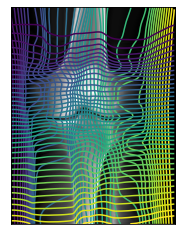

warped_image_grid


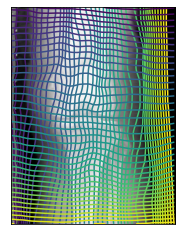

warped_image_grid


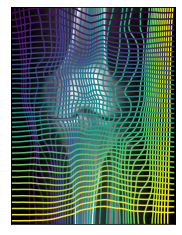

In [601]:
for _ in range(25):
    N += 1
    N %= 128
    print("warped_image_grid")
    lines = np.arange(0, 1, 1/40)

    plt.contour(netGrad.phi_BA_vectorfield[N, 1].detach().cpu(), lines)
    plt.contour(netGrad.phi_BA_vectorfield[N, 0].detach().cpu(), lines)

    show(netGrad.warped_image_B[N, 0])

In [602]:
atlas.shape

torch.Size([1, 1, 212, 160])

In [603]:
torch.mean(netGrad.warped_image_B, axis=0).shape

torch.Size([2, 212, 160])

In [ ]:
pip install antspyx

In [490]:
import ants
imageA_ants = ants.from_numpy(image_A[0, 0].detach().cpu().numpy())
imageB_ants = ants.from_numpy(image_B[0, 0].detach().cpu().numpy())

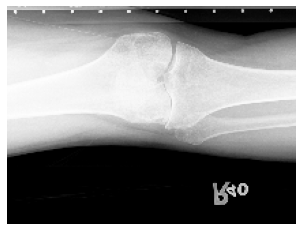

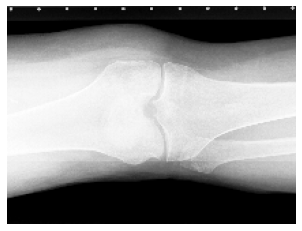

In [494]:
imageA_ants.plot()
imageB_ants.plot()

In [495]:
mytx = ants.registration(fixed=imageA_ants , moving=imageB_ants, type_of_transform='SyN' )

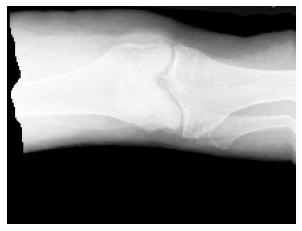

In [500]:
warped_moving = mytx['warpedmovout']
warped_moving.plot()

In [497]:
netGrad(image_A, image_B)

ICONLoss(all_loss=tensor(0.9428, device='cuda:0', grad_fn=<AddBackward0>), inverse_consistency_loss=tensor(0.0114, device='cuda:0', grad_fn=<AddBackward0>), similarity_loss=tensor(0.9086, device='cuda:0', grad_fn=<AddBackward0>), transform_magnitude=tensor(0.0086, device='cuda:0', grad_fn=<MeanBackward0>), flips=tensor(0.))

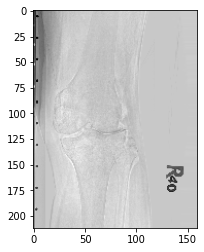

In [504]:
show(netGrad.warped_image_B[0, 0] - image_A[0, 0])